In [1]:
import numpy as np
import pickle
import json
import os
import sys
import copy
import sklearn.preprocessing
import models
from sklearn.neighbors import NearestNeighbors
import utils
from collections import Counter
import matplotlib.pyplot as plt

In [2]:
DATA_DIR = "../../data/yago/"
DUMP_FILE = "../dumps/yago_distmult_dump_norm.pkl"
MODEL_TYPE = "yago"
mining_dir="mined_yago/"

In [3]:
train_data = utils.read_data(os.path.join(DATA_DIR,"train.txt"))
# dev_data = read_data(os.path.join(DATA_DIR,"valid.txt"))
# test_data = read_data(os.path.join(DATA_DIR,"test.txt"))

In [4]:
dump=utils.load_pickle(DUMP_FILE)
dump.keys()

dict_keys(['entity_real', 'head_rel_type', 'tail_rel_type', 'rel_real', 'relation_to_id', 'entity_type', 'entity_to_id'])

In [5]:
model=models.TypedDM(DUMP_FILE)

In [6]:
mapped_train_data = utils.map_data(train_data,dump)
# mapped_dev_data = map_data(dev_data)
# mapped_test_data = map_data(test_data)

In [7]:
entity_to_rel=utils.get_ent_to_rel(mapped_train_data)

# Length 1 Rules

In [8]:
relation_count=len(dump['relation_to_id'])
nbrs = NearestNeighbors(n_neighbors=relation_count,metric=model.similarity_relembedding).fit(model.relation_matrix)
print(relation_count)
count_r,set_r=utils.get_relation_dict(mapped_train_data)
print(len(count_r),len(set_r))
support=4

37
37 37


In [37]:
rules_dict_1={}
count=0
count2=0
for r1 in range(relation_count):
    if(r1%100==0):
        print(r1)
    if(count_r[r1]<support):
        continue
    combined_rel=model.relation_matrix[r1].reshape((1,-1))
    distances, indices = nbrs.kneighbors(combined_rel)
    indices=indices[0]
    bool_arr=[False for i in range(relation_count)]
    for ind in indices:
        if ind!=r1:
            bool_arr[ind]=True
    cur_dict={}
    for pair_e1e2 in set_r[r1]:
        if pair_e1e2 not in entity_to_rel:
            print("Strange")
            continue
        for r2 in entity_to_rel[pair_e1e2]:
            count+=1
            if bool_arr[r2]==False:
                continue
            if r2 not in cur_dict:
                count2+=1
                cur_dict[r2]=0
            cur_dict[r2]+=1
    rules_dict_1[r1]=cur_dict            

0


In [38]:
print(len(rules_dict_1))
print(count,count2)

37
1652846 112


# Length 2 Rules

In [9]:
index_head=utils.get_head_index(mapped_train_data)
count_r1_r2,set_r1_r2=utils.get_r1r2_count(mapped_train_data,index_head,get_set=True)

In [10]:
nbrs = NearestNeighbors(n_neighbors=30,metric=model.similarity_relembedding).fit(model.relation_matrix)
support=4

In [41]:
count=0
rules_dict={}
for r1 in range(relation_count):
    if(r1%100==0):
        print(r1)
    for r2 in range(relation_count):
        if(r1==r2):
            continue
        pair=(r1,r2)
        if(pair not in count_r1_r2 or count_r1_r2[pair]<support):
            continue
        
        combined_rel=model.dot_relation(r1,r2).reshape((1,-1))
        distances, indices = nbrs.kneighbors(combined_rel)
        
        bool_arr=[False for i in range(relation_count)]
        for ind in indices[0]:
            if ind!=r1 and ind!=r2:
                bool_arr[ind]=True
        
        if bool_arr[r1]==True or bool_arr[r2]==True:
            print("Strange")
            print(indices[0],r1,r2)
        
        cur_dict={}
        entpair_lis=list(set_r1_r2[pair])
        for pair_e1e2 in entpair_lis:
            if pair_e1e2 not in entity_to_rel:
                continue
            for r in entity_to_rel[pair_e1e2]:
                if(bool_arr[r]==False):
                    continue
                if r not in cur_dict:
                    count+=1
                    cur_dict[r]=0
                cur_dict[r]+=1
        rules_dict[pair]=cur_dict
        

0


In [42]:
print(len(rules_dict))
print(relation_count)
print(count)

316
37
288


# Saving rules

In [43]:
path1='rules_1_1.pkl'
path1=os.path.join(mining_dir,path1)
utils.dump_pickle(rules_dict_1,path1)

In [44]:
path2='rules_2_1.pkl'
path2=os.path.join(mining_dir,path2)
utils.dump_pickle(rules_dict,path2)

## Saving auxilary data for rule2

In [45]:
path='set_r1_r2.pkl'
path=os.path.join(mining_dir,path)
set_len_r1_r2={}
for r1r2 in set_r1_r2:
    set_len_r1_r2[r1r2]=len(set_r1_r2[r1r2])
utils.dump_pickle(set_len_r1_r2,path)

In [27]:
print(len(count_r1_r2))

386


## Analyse 3 Rules

In [28]:
min_sup=4
confidence=0

In [29]:
rules_3=[]
count=0
count_dict={}

for r1r2 in set_r1_r2:
#     prit(r1r2)
    count+=1
    if(count%100==0):
        print(count)
    for e1e2 in set_r1_r2[r1r2]:
        e1=e1e2[0]
        e2=e1e2[1]
        # e1-r1-e-r2-e2
        count_conf_dict={}
#         count_dict={}
        
        # e1-r1-e-r2-e2-r3-e3
        if e2 not in index_head:
            continue
        for r3e3 in index_head[e2]:
            e3=r3e3[1]
            triplet=(r1r2[0],r1r2[1],r3e3[0])
            if triplet not in count_dict:
                count_dict[triplet]=0
                count_conf_dict[triplet]={}
            count_dict[triplet]+=1
            
#             pair=(e1,e3)
#             if pair not in entity_to_rel:
#                 continue
#             for rel in entity_to_rel[pair]:
#                 if rel not in count_conf_dict[triplet]:
#                     count_conf_dict[triplet][rel]=0
#                 count_conf_dict[triplet][rel]+=1
        
#         for r1r2r3,supp in count_dict.items():
#             if supp < min_sup:
#                 continue
#             for r4,conf in count_conf_dict[r1r2r3].items():
#                 rules_3.append((r1r2r3,r4,supp,conf))           
        

100
200
300


In [30]:
print(len(count_dict))

2029


In [31]:
value_list=list(count_dict.values())
cnt=Counter(value_list)
cnt=sorted(cnt.items())
array=np.array(cnt)
print(array.shape)

(964, 2)


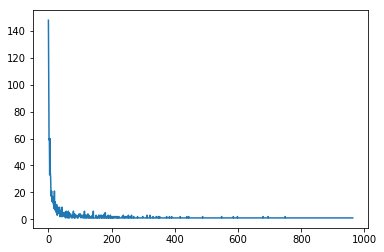

In [32]:
plt.plot(array[:,1])
plt.show()

In [ ]:
temp=np.cumsum(array[:,1])/np.sum(array[:,1])
print(array[temp[:]<0.5],temp[temp[:]<0.5])

## Rules Length 3

In [11]:
min_sup=4
confidence=0
r1r2_ent=utils.get_r1r2_e1e2_dict(mapped_train_data,index_head)

In [12]:
rules_3=[]
count=0

for r1r2 in set_r1_r2:
#     prit(r1r2)
    count+=1
    if(count%100==0):
        print(count)
        print(len(rules_3))
    for e1e2 in set_r1_r2[r1r2]:
        e1=e1e2[0]
        e2=e1e2[1]
        # e1-r1-e-r2-e2
        e=r1r2_ent[r1r2][e1e2]
        count_conf_dict={}
        count_dict={}
        
        # e1-r1-e-r2-e2-r3-e3
        if e2 not in index_head:
            continue
        for r3e3 in index_head[e2]:
            e3=r3e3[1]
            triplet=(r1r2[0],r1r2[1],r3e3[0])
            if triplet not in count_dict:
                count_dict[triplet]=0
                count_conf_dict[triplet]={}
            count_dict[triplet]+=1
            
            pair=(e1,e3)
            if pair not in entity_to_rel:
                continue
            for rel in entity_to_rel[pair]:
                if rel not in count_conf_dict[triplet]:
                    count_conf_dict[triplet][rel]=0
                count_conf_dict[triplet][rel]+=1
        
        for r1r2r3,supp in count_dict.items():
            if supp < min_sup:
                continue
            for r4,conf in count_conf_dict[r1r2r3].items():
                rules_3.append((r1r2r3,r4,supp,conf,e,e2))           
        

100
1042958
200
1133608
300
1136498


In [13]:
rules_3.sort(key=lambda x:(x[3]*1.0)/x[2],reverse=True)

In [14]:
path_rule_3=os.path.join(mining_dir,"mined_3_ent.pkl")

In [15]:
utils.dump_pickle(rules_3,path_rule_3)

## Load Len 3 rules

In [16]:
rules_3=utils.load_pickle(path_rule_3)

In [17]:
rules_3[0:10]

[((0, 30, 0), 0, 5, 9, 4467, 4467),
 ((0, 0, 0), 0, 5, 9, 4467, 4467),
 ((30, 0, 0), 0, 5, 9, 4467, 4467),
 ((30, 30, 0), 0, 5, 9, 4467, 4467),
 ((0, 0, 0), 0, 7, 9, 4467, 7639),
 ((0, 12, 0), 0, 4, 4, 268, 96842),
 ((0, 12, 8), 8, 4, 4, 268, 96842),
 ((0, 12, 8), 8, 4, 4, 10955, 96005),
 ((0, 12, 8), 8, 6, 6, 90199, 75683),
 ((0, 12, 8), 0, 4, 4, 16440, 73420)]